In [61]:
import torch
import torch.optim as optim
import sys
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import random
import cv2
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import transforms
from torchvision.models.detection import fasterrcnn_resnet50_fpn, fasterrcnn_mobilenet_v3_large_320_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchmetrics.detection.mean_ap import MeanAveragePrecision
from PIL import Image
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
from torchvision.models.detection import SSDLite320_MobileNet_V3_Large_Weights
BATCH_SIZE=8
from transformers import DetrImageProcessor, DetrForObjectDetection

In [94]:


# class Resizer(object):
#     def __call__(self, image, target, min_side=300, max_side=300):
#         image, annots = image, target['boxes']
#         rows, cols, cns = image.shape
#         smallest_side = min(rows, cols)
#         # rescale the image so the smallest side is min_side
#         scale = min_side / smallest_side
#         # check if the largest side is now greater than max_side, which can happen
#         # when images have a large aspect ratio
#         largest_side = max(rows, cols)
#         if largest_side * scale > max_side:
#             scale = max_side / largest_side
#         # resize the image with the computed scale
#         image = skimage.transform.resize(image, (int(round(rows*scale)), int(round((cols*scale)))))
#         rows, cols, cns = image.shape
#         pad_w = 32 - rows%32
#         pad_h = 32 - cols%32
#         new_image = np.zeros((rows + pad_w, cols + pad_h, cns)).astype(np.float32)
#         new_image[:rows, :cols, :] = image.astype(np.float32)
#         annots[:, :4] *= scale
#         return {'img': new_image, 'annot': torch.from_numpy(annots), 'scale': scale}

class BallDetectionDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None):
        with open(annotations_file, 'r') as file:
            data = json.load(file)
            self.img_paths = list(data.keys())
            self.img_annots = list(data.values())
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_paths[idx])       
        annot = self.img_annots[idx]        
        image = Image.open(img_path, mode='r')
        image = image.convert('RGB')        
        if self.transform:
            image = self.transform(image)
        w, h = image.shape[1:]
        boxes = []
        for bbox in self.img_annots[idx]:
            xmin = bbox[0] * w
            xmax = bbox[1] * w
            ymin = bbox[2] * h
            ymax = bbox[3] * h
            boxes.append([xmin, ymin, xmax, ymax])            
        boxes = np.asarray(boxes)  # N x 4        
        target = {}
        target['boxes'] = torch.Tensor(boxes)
        target['labels'] = torch.ones((len(boxes),), dtype=torch.int64)        
        return image, target

def collater(data):
    imgs = []
    targets = []
    for image, target in data:
        imgs.append(image)
        targets.append(target)    
    imgs = torch.stack(imgs, dim=0) 
    return imgs, targets

def train(model, optimizer, epoch):
    model.train()
    for i, (imgs, targets) in enumerate(train_dataloader):
        imgs = imgs.to(device)
        targets = [{key: value.to(device) for key, value in target.items()} for target in targets]
        loss_dict = model(imgs, targets)
        loss = sum(list(loss_dict.values()))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()    
        del imgs, targets, loss_dict, loss       
    print("MAP on val_dataset: ", evaluate(model))
    
maps=[]
            
def evaluate(model, dataloader=test_dataloader):
    global maps
    model.eval()
    metric = MeanAveragePrecision(box_format='xyxy')
    metric.reset()
    with torch.no_grad():
        for imgs, targets in dataloader:
            imgs = imgs.to(device)
            targets = [{key: value.to(device) for key, value in target.items()} for target in targets]
            outputs = model(imgs)
            metric.update(outputs, targets)
    maap = metric.compute()['map'].item()
    maps.append(maap)
    return maap 


train_transform = transforms.Compose([
    transforms.transforms.GaussianBlur(kernel_size=3),
    #Resizer(),
    transforms.Resize((1000, 1000)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406], 
        std=[0.229, 0.224, 0.225]
    )
])

test_transform = transforms.Compose([ 
    transforms.Resize((1000, 1000)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406], 
        std=[0.229, 0.224, 0.225]
    )
])

training_data = BallDetectionDataset(
    annotations_file='C:\\Users\\Alex\\Downloads\\seminar_objdet_retina_oi5_ball\\oi5_ball_filename_to_bbox_train.json',
    img_dir='C:\\Users\\Alex\\Downloads\\seminar_objdet_retina_oi5_ball',
    transform=train_transform,
)
train_size = int(0.8 * len(training_data))
test_size = int(0.2*len(training_data))
oth=len(training_data) - train_size-test_size
train_data, test_data,_ = torch.utils.data.random_split(training_data, [train_size, test_size,oth])


train_dataloader = DataLoader(train_data, 
    batch_size=BATCH_SIZE,                       
    collate_fn=collater
)
test_dataloader = DataLoader(test_data, 
    batch_size=BATCH_SIZE,                       
    collate_fn=collater
)

metric = MeanAveragePrecision(box_format='xyxy')

#model = fasterrcnn_mobilenet_v3_large_320_fpn(pretrained=True, pretrained_backbone=True, progress=True)
#model.roi_heads.box_predictor = FastRCNNPredictor(in_channels=model.roi_heads.box_predictor.cls_score.in_features, num_classes=2)

model = torchvision.models.detection.ssdlite320_mobilenet_v3_large(weights=SSDLite320_MobileNet_V3_Large_Weights.DEFAULT, num_classes =91, trainable_backbone_layers = 6)
model.head.classifier = torch.nn.Linear(256, 2) 
model.head.score = torch.nn.Linear(256, 2)  

model = model.to(device)
optimizer = torch.optim.Adam(model.parameters())

print("MAP before learning", evaluate(model))
for i in range(6):
    print("epoch", i+1)
    train(model, optimizer, i)

MAP before learning 0.0013590216403827071
epoch 1
MAP on val_dataset:  0.16684478521347046
epoch 2
MAP on val_dataset:  0.22497496008872986
epoch 3
MAP on val_dataset:  0.23135411739349365
epoch 4
MAP on val_dataset:  0.24210400879383087
epoch 5
MAP on val_dataset:  0.2202916145324707
epoch 6
MAP on val_dataset:  0.2652856111526489


Text(0.5, 0, 'epoch')

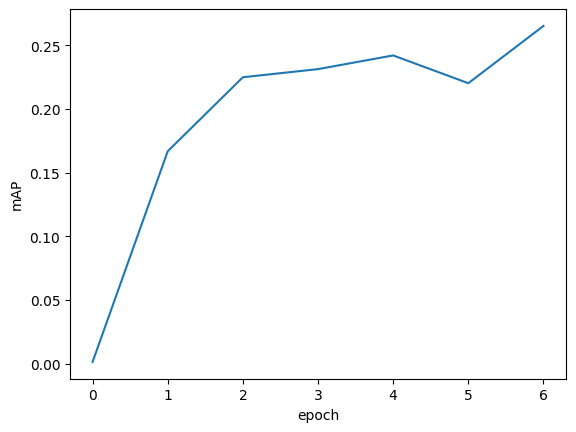

In [97]:
plt.plot(maps)
plt.ylabel('mAP')
plt.xlabel('epoch')

Ход работы и выводы:

1) Выбрала модель детекции - ssdlite320_mobilenet_v3_large. Эта модель сочетает Single Shot Detector (SSD) со сверточной мобильной сетью MobileNet_v3_large, служащей для выделения признаков. Архитектура SSD состоит из нескольких слоев, включая слой обнаружения объектов, слой классификации и слой регрессии. Важным преимуществом модели является быстродействие.
2) Реализовала класс BallDetectionDataset, преобразующий данные в датасет, пригодный для подачи в torch.utils.data.Dataloader.
3) Добавила простые и сложные аугментации(Normalize, Resize, GaussianBlur, RandomRotation )
4) Реализовала train-loop с проверкой величины метрики mAP на валидационном датасете. Использовала оптимизатор Adam.

 Оценка влияния дообучения предобученной модели: MAP before learning 0.0004252800717949867, MAP on val_dataset:  0.26899640828371405 (epoch 6), т.е. дообучение позволило сильно увеличить качество.

 Помимо стандартных аугментаций кажется логичным применить аугментацию RandomRotation, тк детектируемый объект не меняет вид после поворота. Переобучения нет, скор на валидации растет. В то же время, кажется это негативно влияет на скор, тк координаты bounding box не поворачиваются.
Наиболее положительное влияние оказал GaussianBlur, не влияющий на координаты.

 Наибольшую опасность для детекции мячей представляет метод Resize, искажающий круглую форму мячей. В то же время приводить все картинки к единому размеру необходимо. Можно пропорционально увеличивать длину и ширину пока одна из них не привысит заданный размер, а далее использовать обрамление из нулей чтобы придать нужную форму. Так же нужно проводить все эти преобразования с координатами bounding box.

 